Following https://huggingface.co/blog/fine-tune-vit

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in June 2021 by a team of researchers at Google Brain.
This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. It's quite a simple concept, really...

Split an image into a grid of sub-image patches
Embed each patch with a linear projection
Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

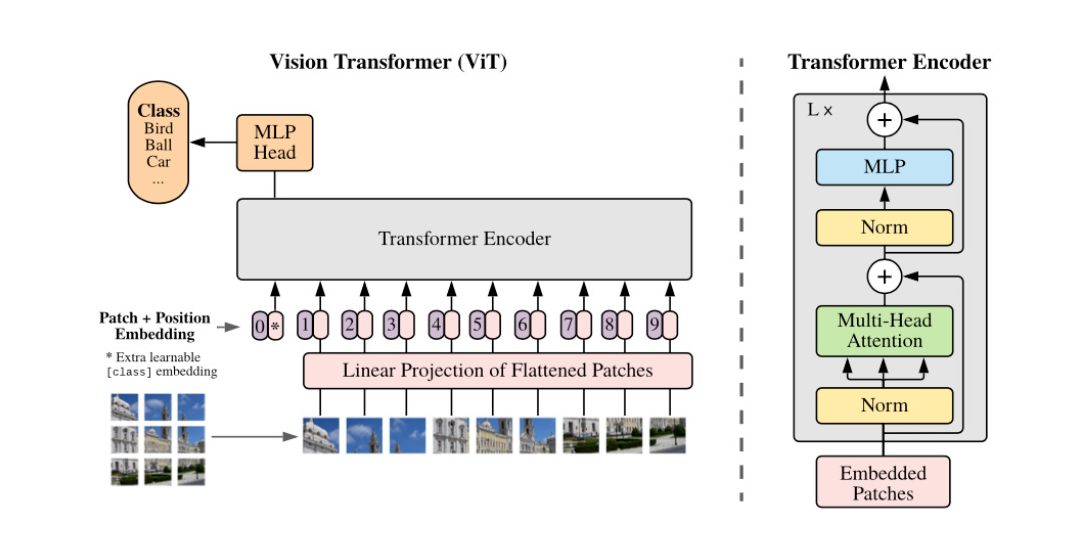

In [4]:
%pip install datasets transformers accelerate

Note: you may need to restart the kernel to use updated packages.


In [5]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [6]:
ex = ds['train'][400]
ex

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

In [7]:
image = ex['image']
# print(ds.train.features[ex['labels']])


In [8]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [9]:
labels.int2str(ex["labels"])

'bean_rust'

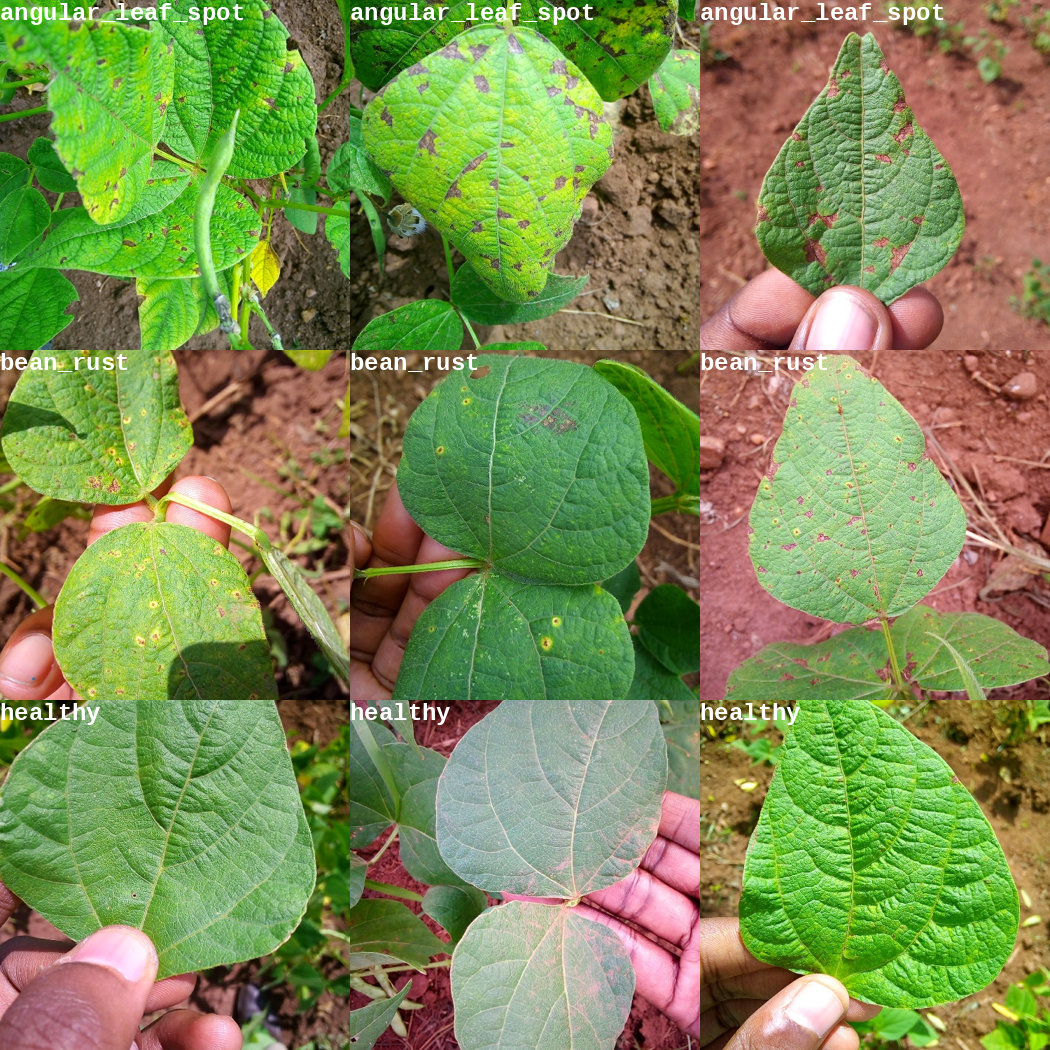

In [10]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [11]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

display(processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
result = processor(image, return_tensors='pt')
result

{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7098,  0.6000,  0.6784,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4902,  0.3882,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8353]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7255, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0588,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9686, -0.9529, -0.9294],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.2941, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4196,  0.2706,  0.3020,  ..., -0.7098, -0.6392, -0.6863],
          [ 0

In [13]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [14]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

#### Define our data collator
Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.

Since the collate_fn will return a batch dict, you can **unpack the inputs to the model later. ✨

In [15]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }



### Define an evaluation metric
* The accuracy metric from datasets can easily be used to compare the predictions with the labels. 
* Below, you can see how to use it within a compute_metrics function that will be used by the Trainer.

In [16]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_42246/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/home/vadim/src/playground/.conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [17]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='mlflow',
  load_best_model_at_end=True,
)

/home/vadim/src/playground/.conda/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

/home/vadim/src/playground/.conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [20]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.059800,0.035707,1.000000
200,0.018600,0.100433,0.969925


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1275
  train_runtime            =  0:08:30.11
  train_samples_per_second =       8.108
  train_steps_per_second   =        0.51
